In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
# setting the device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


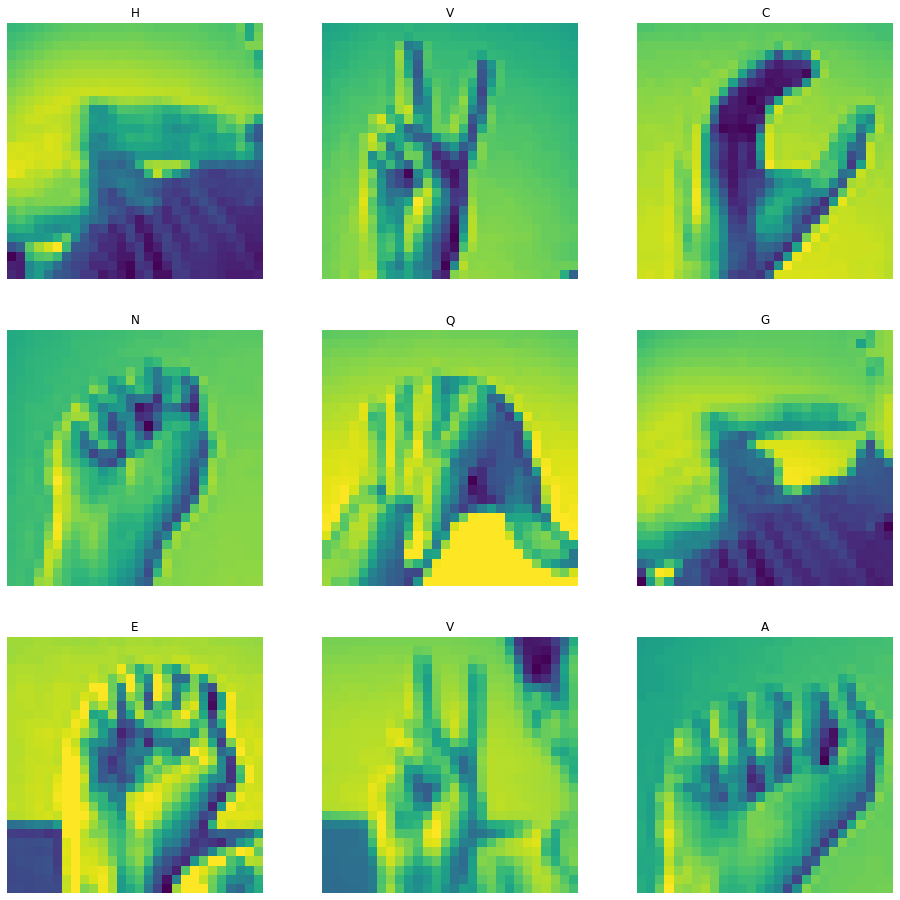

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/HW2/Data/HW2_data/Q3_train.csv')
df = pd.DataFrame(train_data)
b=torch.randperm(len(df))[:9]
random_data = df.loc[b]
figure = plt.figure(figsize=(16, 16))
cols, rows = 3, 3

for i in range(len(random_data)):
    label = random_data.iloc[i].values[0]
    image = random_data.iloc[i].values[1:]
    image = (image - image.mean())/ np.std(image)
    figure.add_subplot(rows, cols, i+1)
    plt.title(chr(65+label))
    plt.axis("off")
    plt.imshow(image.reshape(28,28))
plt.show()

In [4]:
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.features[idx]
        sample = ( data, label)
        return sample

In [5]:
train_image = torch.tensor(df.drop('label',axis=1).values).type(torch.float32)
train_image = (train_image-torch.unsqueeze(train_image.mean(dim=1),dim=1))/torch.unsqueeze(torch.std(train_image,dim=1),dim=1)
train_label = torch.tensor(df['label'].values)
training_data = MyDataset(train_image, train_label)

In [6]:
test_data = pd.read_csv('/content/drive/MyDrive/HW2/Data/HW2_data/Q3_test.csv')
df_test = pd.DataFrame(test_data)
test_image = torch.tensor(df_test.drop('label',axis=1).values).type(torch.float32)
test_image = (test_image-torch.unsqueeze(test_image.mean(dim=1),dim=1))/torch.unsqueeze(torch.std(test_image,dim=1),dim=1)
test_label = torch.tensor(df_test['label'].values)
test_data = MyDataset(test_image, test_label)


In [7]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## SGD & Adam Without Dropout:

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
            super(NeuralNetwork, self).__init__()
            self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 26),
        )


    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    

In [9]:
model = NeuralNetwork().to(device)
X = torch.rand(1, 784, device=device) # creating a random input with the same device

# passing the input to the model
logits = model(X)
print(f"Model's output: \n {logits} \n")

# calculating model predictions by applying a softmax
probs = nn.Softmax(dim=1)(logits) # finding the probabilities
print(f"Prediction probabilities: \n {probs} \n")

y_pred = probs.argmax(dim = 1)
print(f"Predicted label: \n {y_pred.item()} \n")

Model's output: 
 tensor([[-0.0347,  0.1185,  0.1264,  0.0047,  0.1485,  0.0356,  0.0134, -0.0197,
          0.0173, -0.0340,  0.0003, -0.0184,  0.0458, -0.0882,  0.0869,  0.0774,
          0.0603,  0.0810, -0.0138,  0.0366,  0.0102, -0.0560,  0.0204, -0.0532,
          0.0434, -0.0449]], device='cuda:0', grad_fn=<AddmmBackward0>) 

Prediction probabilities: 
 tensor([[0.0363, 0.0423, 0.0426, 0.0377, 0.0436, 0.0389, 0.0381, 0.0368, 0.0382,
         0.0363, 0.0376, 0.0369, 0.0393, 0.0344, 0.0410, 0.0406, 0.0399, 0.0407,
         0.0371, 0.0390, 0.0380, 0.0355, 0.0383, 0.0356, 0.0392, 0.0359]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>) 

Predicted label: 
 4 



In [10]:
model = NeuralNetwork().to(device)
# setting models mode to train mode

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        model.train()
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            model.eval()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [12]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
test_accuracy = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_accuracy.append(test_loop(test_dataloader, model, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 3.300548  [    0/27455]
loss: 3.258546  [ 6400/27455]
loss: 3.248648  [12800/27455]
loss: 3.186014  [19200/27455]
loss: 3.213674  [25600/27455]
Test Error: 
 Accuracy: 10.3%, Avg loss: 3.205872 

Epoch 2
-------------------------------
loss: 3.193329  [    0/27455]
loss: 3.168836  [ 6400/27455]
loss: 3.138165  [12800/27455]
loss: 3.116569  [19200/27455]
loss: 3.110843  [25600/27455]
Test Error: 
 Accuracy: 19.5%, Avg loss: 3.123583 

Epoch 3
-------------------------------
loss: 3.095934  [    0/27455]
loss: 3.070235  [ 6400/27455]
loss: 3.040491  [12800/27455]
loss: 3.041099  [19200/27455]
loss: 2.999474  [25600/27455]
Test Error: 
 Accuracy: 26.1%, Avg loss: 3.018917 

Epoch 4
-------------------------------
loss: 2.994628  [    0/27455]
loss: 2.964954  [ 6400/27455]
loss: 2.946918  [12800/27455]
loss: 2.782248  [19200/27455]
loss: 2.799338  [25600/27455]
Test Error: 
 Accuracy: 30.2%, Avg loss: 2.880902 

Epoch 5
------------------------

In [ ]:
print(f" The Best Test Accuracy of Model Without Dropout & With SGD Optimization in 10 epochs: {(100*max(test_accuracy)):>0.1f}%")

In [ ]:
epochs = 90
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_accuracy.append(test_loop(test_dataloader, model, loss_fn))
print("Done!")

In [ ]:
print(f" The Best Test Accuracy of Model Without Dropout & With SGD Optimization in 100 epochs: {(100*max(test_accuracy)):>0.1f}%")

In [ ]:
model1 = NeuralNetwork().to(device)
# setting models mode to train mode
model1.train()
loss_fn1 = nn.CrossEntropyLoss()
learning_rate = 1e-3
epochs = 10
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)
test_accuracy1 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model1, loss_fn1, optimizer1)
    test_accuracy1.append(test_loop(test_dataloader, model1, loss_fn1))
print("Done!")

In [ ]:
print(f" The Best Test Accuracy of Model Without Dropout & With Adam Optimization in 10 epochs: {(100*max(test_accuracy1)):>0.1f}%")

## SGD & Adam Performance:
Adam is faster than SGD. If numbers of epochs were equal, Adam performs better. The performance of Adam in 10 epochs is almost equal to SGD in 100 epochs.


##SGD & Adam With Dropout:##


In [13]:
class NeuralNetwork1(nn.Module):
    def __init__(self):
            super(NeuralNetwork1, self).__init__()
            self.linear_relu_stack = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 26),
        )


    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    

In [14]:
model2 = NeuralNetwork1().to(device)
X = torch.rand(1, 784, device=device) # creating a random input with the same device

# passing the input to the model
model2.eval()
logits = model2(X)
print(f"Model's output: \n {logits} \n")

# calculating model predictions by applying a softmax
probs = nn.Softmax(dim=1)(logits) # finding the probabilities
print(f"Prediction probabilities: \n {probs} \n")

y_pred = probs.argmax(dim = 1)
print(f"Predicted label: \n {y_pred.item()} \n")

Model's output: 
 tensor([[-0.1463,  0.0251, -0.0161, -0.0710,  0.1489,  0.0735, -0.0777, -0.0491,
         -0.0433,  0.0717,  0.0160,  0.0131, -0.0393,  0.0262,  0.0372,  0.0822,
         -0.0643,  0.0040,  0.1559, -0.0067, -0.0770, -0.0203,  0.0009, -0.0243,
          0.0576,  0.1286]], device='cuda:0', grad_fn=<AddmmBackward0>) 

Prediction probabilities: 
 tensor([[0.0329, 0.0390, 0.0375, 0.0355, 0.0442, 0.0410, 0.0352, 0.0362, 0.0364,
         0.0409, 0.0387, 0.0386, 0.0366, 0.0391, 0.0395, 0.0413, 0.0357, 0.0382,
         0.0445, 0.0378, 0.0352, 0.0373, 0.0381, 0.0371, 0.0403, 0.0433]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>) 

Predicted label: 
 18 



In [15]:
loss_fn2 = nn.CrossEntropyLoss()
learning_rate = 1e-3
epochs = 10
optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate)
test_accuracy2 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model2, loss_fn2, optimizer2)
    test_accuracy2.append(test_loop(test_dataloader, model2, loss_fn2))
print("Done!")

Epoch 1
-------------------------------
loss: 3.281720  [    0/27455]
loss: 3.292436  [ 6400/27455]
loss: 3.253316  [12800/27455]
loss: 3.247947  [19200/27455]
loss: 3.235626  [25600/27455]
Test Error: 
 Accuracy: 10.6%, Avg loss: 3.200790 

Epoch 2
-------------------------------
loss: 3.234604  [    0/27455]
loss: 3.201020  [ 6400/27455]
loss: 3.191581  [12800/27455]
loss: 3.163891  [19200/27455]
loss: 3.129514  [25600/27455]
Test Error: 
 Accuracy: 20.6%, Avg loss: 3.138435 

Epoch 3
-------------------------------
loss: 3.108288  [    0/27455]
loss: 3.125072  [ 6400/27455]
loss: 3.106627  [12800/27455]
loss: 3.037021  [19200/27455]
loss: 3.116808  [25600/27455]
Test Error: 
 Accuracy: 25.1%, Avg loss: 3.066905 

Epoch 4
-------------------------------
loss: 3.035670  [    0/27455]
loss: 3.010229  [ 6400/27455]
loss: 3.105253  [12800/27455]
loss: 2.988958  [19200/27455]
loss: 3.011179  [25600/27455]
Test Error: 
 Accuracy: 29.1%, Avg loss: 2.975655 

Epoch 5
------------------------

In [16]:
print(f" The Best Test Accuracy of Model With Dropout & With SGD Optimization in 10 epochs: {(100*max(test_accuracy2)):>0.1f}%")

 The Best Test Accuracy of Model With Dropout & With SGD Optimization in 10 epochs: 42.9%


In [17]:
epochs = 90
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model2, loss_fn2, optimizer2)
    test_accuracy2.append(test_loop(test_dataloader, model2, loss_fn2))
print("Done!")

Epoch 1
-------------------------------
loss: 2.040933  [    0/27455]
loss: 2.078719  [ 6400/27455]
loss: 2.033846  [12800/27455]
loss: 2.108652  [19200/27455]
loss: 2.197705  [25600/27455]
Test Error: 
 Accuracy: 46.3%, Avg loss: 1.958464 

Epoch 2
-------------------------------
loss: 1.980467  [    0/27455]
loss: 2.030807  [ 6400/27455]
loss: 1.988026  [12800/27455]
loss: 2.019105  [19200/27455]
loss: 1.825599  [25600/27455]
Test Error: 
 Accuracy: 48.7%, Avg loss: 1.852210 

Epoch 3
-------------------------------
loss: 1.909315  [    0/27455]
loss: 1.893788  [ 6400/27455]
loss: 1.917554  [12800/27455]
loss: 1.846722  [19200/27455]
loss: 1.969877  [25600/27455]
Test Error: 
 Accuracy: 47.9%, Avg loss: 1.772447 

Epoch 4
-------------------------------
loss: 1.963688  [    0/27455]
loss: 1.924708  [ 6400/27455]
loss: 1.517390  [12800/27455]
loss: 1.746292  [19200/27455]
loss: 1.621226  [25600/27455]
Test Error: 
 Accuracy: 51.3%, Avg loss: 1.675241 

Epoch 5
------------------------

In [18]:
print(f" The Best Test Accuracy of Model With Dropout & With SGD Optimization in 100 epochs: {(100*max(test_accuracy2)):>0.1f}%")

 The Best Test Accuracy of Model With Dropout & With SGD Optimization in 100 epochs: 79.4%


In [19]:
model3 = NeuralNetwork1().to(device)
loss_fn3 = nn.CrossEntropyLoss()
learning_rate = 1e-3
epochs = 10
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)
test_accuracy3 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model3, loss_fn3, optimizer3)
    test_accuracy3.append(test_loop(test_dataloader, model3, loss_fn3))
print("Done!")

Epoch 1
-------------------------------
loss: 3.253082  [    0/27455]
loss: 0.918643  [ 6400/27455]
loss: 0.715941  [12800/27455]
loss: 0.425486  [19200/27455]
loss: 0.246434  [25600/27455]
Test Error: 
 Accuracy: 81.1%, Avg loss: 0.595562 

Epoch 2
-------------------------------
loss: 0.211407  [    0/27455]
loss: 0.220561  [ 6400/27455]
loss: 0.158036  [12800/27455]
loss: 0.131955  [19200/27455]
loss: 0.053087  [25600/27455]
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.540940 

Epoch 3
-------------------------------
loss: 0.189148  [    0/27455]
loss: 0.117676  [ 6400/27455]
loss: 0.074066  [12800/27455]
loss: 0.066847  [19200/27455]
loss: 0.233976  [25600/27455]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.622361 

Epoch 4
-------------------------------
loss: 0.224243  [    0/27455]
loss: 0.114013  [ 6400/27455]
loss: 0.081046  [12800/27455]
loss: 0.060182  [19200/27455]
loss: 0.110769  [25600/27455]
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.637455 

Epoch 5
------------------------

In [20]:
print(f" The Best Test Accuracy of Model With Dropout & With Adam Optimization in 10 epochs: {(100*max(test_accuracy3)):>0.1f}%")

 The Best Test Accuracy of Model With Dropout & With Adam Optimization in 10 epochs: 86.9%


## SGD & Adam with Dropout Performance:
Adam is faster than SGD. in 1. The performance of Adam with dropout is better than Adam without it. In SGD with dropout, the performance is almost the same wihout it.The performance of Adam with dropout in 10 epochs is even better than SGD in 100 epochs.

##The Best Moel:##

In [21]:
print(f" The Best Model Is The Moel With Dropout & With Adam Optimization in 10 epochs and its best test accuracy is: {(100*max(test_accuracy3)):>0.1f}%")

 The Best Model Is The Moel With Dropout & With Adam Optimization in 10 epochs and its best test accuracy is: 86.9%


##Bonus##
I gave 3 images of C,E,O to my best model (The Best Model Is The Moel With Dropout & With Adam Optimization).

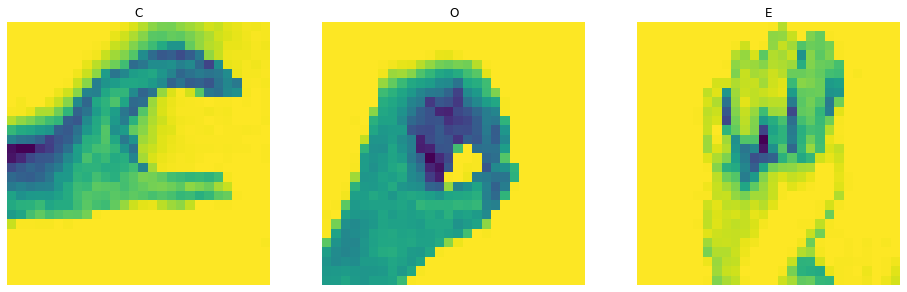

In [22]:

import matplotlib.pyplot as plt
import cv2
# Read Images
C_img = cv2.imread('/content/drive/MyDrive/HW2/Data/HW2_data/C.jpg')
O_img = cv2.imread('/content/drive/MyDrive/HW2/Data/HW2_data/O.jpg')
E_img = cv2.imread('/content/drive/MyDrive/HW2/Data/HW2_data/E.jpg')
C_img = C_img[200:500, 250:550, :]
E_img = E_img[50:300, 250:650, :]
O_img = O_img[150:350, 300:600, :]

#I use method in https://pillow.readthedocs.io/en/stable/reference/Image.html for make greyscal images

C_img = 0.2989 * C_img[:, :,0]+ 0.5870 * C_img[:, :,1] + 0.1140 * C_img[:, :,2]
O_img = 0.2989 * O_img[:, :,0]+ 0.5870 * O_img[:, :,1] + 0.1140 * O_img[:, :,2]
E_img = 0.2989 * E_img[:, :,0]+ 0.5870 * E_img[:, :,1] + 0.1140 * E_img[:, :,2]
C_img = cv2.resize(C_img, (28, 28))
O_img = cv2.resize(O_img, (28, 28))
E_img = cv2.resize(E_img, (28, 28))
# confirm image shape
figure = plt.figure(figsize=(16, 16))
cols, rows = 3, 1
figure.add_subplot(rows, cols, 1)
plt.axis("off")
plt.title('C')
plt.imshow(C_img)
figure.add_subplot(rows, cols, 2)
plt.axis("off")
plt.title('O')
plt.imshow(O_img)
figure.add_subplot(rows, cols, 3)
plt.axis("off")
plt.title('E')
plt.imshow(E_img)

plt.show()


In [23]:
C_data = torch.tensor(C_img).reshape(1,784).to(device).type(torch.float32)
C_data = (C_data -C_data.mean())/torch.std(C_data)
E_data = torch.tensor(E_img).reshape(1,784).to(device).type(torch.float32)
E_data = (E_data -E_data.mean())/torch.std(E_data)
O_data = torch.tensor(O_img).reshape(1,784).to(device).type(torch.float32)
O_data = (O_data -O_data.mean())/torch.std(O_data)

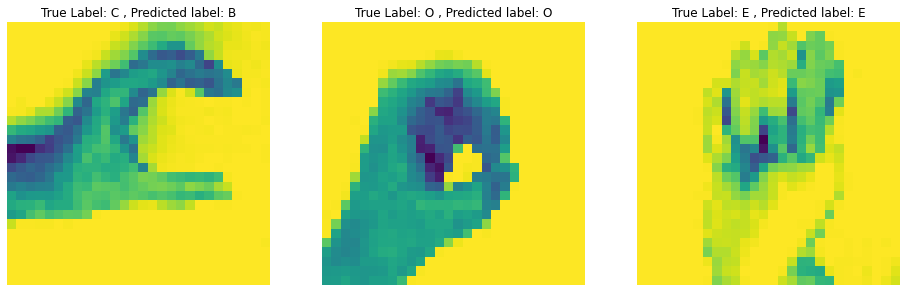

In [24]:
figure = plt.figure(figsize=(16, 16))
cols, rows = 3, 1
model3.eval()
logits = model3(C_data)
probs = nn.Softmax(dim=1)(logits)
y_pred = probs.argmax(dim = 1)
figure.add_subplot(rows, cols, 1)
plt.axis("off")
plt.title("True Label: C , Predicted label: "+ chr(65+y_pred.item()))
plt.imshow(C_img)
figure.add_subplot(rows, cols, 2)
plt.axis("off")
logits = model3(O_data)
probs = nn.Softmax(dim=1)(logits)
y_pred = probs.argmax(dim = 1)
plt.axis("off")
plt.title("True Label: O , Predicted label: "+ chr(65+y_pred.item()))
plt.imshow(O_img)
figure.add_subplot(rows, cols, 3)
plt.axis("off")
logits = model3(E_data)
probs = nn.Softmax(dim=1)(logits)
y_pred = probs.argmax(dim = 1)
plt.axis("off")
plt.title("True Label: E , Predicted label: "+ chr(65+y_pred.item()))
plt.imshow(E_img)
plt.show()